# PLSI IMPLEMENTATION ON SPARK 

# 1. Libraries and file importation

In [17]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import findspark
findspark.init("/Users/amirbenmahjoub/Desktop/spark-2.2.0-bin-hadoop2.7")
import pyspark
from numpy import random 

In [18]:
# importing the short csv file of ratings and save it in the right format. 
pd.read_csv("ratings.csv").to_csv("ratings_short.csv",sep=',',index=False)

In [19]:
# Opening a Spark context
sc = pyspark.SparkContext()

In [16]:
# Shutting down the Spark contect (optional)
#sc.stop()

In [20]:
#Some basic information on the database
ratings_short = pd.read_csv("ratings_short.csv")
ratings_short.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [21]:
print("number of different ratings : ", ratings_short.shape[0])

number of different ratings :  100004


In [22]:
print("number of different users : ", ratings_short.drop_duplicates(subset=['userId']).shape[0])

number of different users :  671


In [23]:
#importing the document - creating the RDD object. 
document = sc.textFile("/Users/amirbenmahjoub/Desktop/3A Polytechnique/Database Management Systems/Data Management II-20180228/Project/PLSI/ratings_short.csv")

# Removing the header
header = document.first()
document = document.filter(lambda x: x != header)

# Collecting the RDD to check the output
document.collect()[0:10]

['1,31,2.5,1260759144',
 '1,1029,3.0,1260759179',
 '1,1061,3.0,1260759182',
 '1,1129,2.0,1260759185',
 '1,1172,4.0,1260759205',
 '1,1263,2.0,1260759151',
 '1,1287,2.0,1260759187',
 '1,1293,2.0,1260759148',
 '1,1339,3.5,1260759125',
 '1,1343,2.0,1260759131']

# 2. The algorithm

## 2.1. Methodology : Running the 1st iteration of the algorithm step-by-step

In [24]:
# A parser for extracting the interresting information from the dataset.

def parseLine(line):
    line = line.split(',')
    # We want to keep only the two first rows since we consider that a click-log is a 1-rating
    line = line[0]+','+line[1]
    return(line)

In [25]:
# Defining the number of clusters. 
# nb of 'clusters' is a broadcast variable.
nb_z = sc.broadcast(3)

In [26]:
# for a click-log couple (u,s), create a z tuples : [(u,s,z) for z in [1:nb_z]]

def cartesianProd(us):
    to_return = []
    for z in range(nb_z.value):
        to_return += [us+','+str(z)]
    return(to_return)

In [27]:
# creation of the tuples (u,s,z ; q*) with (u,s,z) as key.
# We initialize q* randomly as the Google paper suggests. 

q0 = document.map(parseLine).flatMap(cartesianProd).map(lambda usz : (usz, random.rand()))
q0.collect()[0:12]

[('1,31,0', 0.306719161308564),
 ('1,31,1', 0.0669864792985333),
 ('1,31,2', 0.36536465897384085),
 ('1,1029,0', 0.9166589410183121),
 ('1,1029,1', 0.7192665553088856),
 ('1,1029,2', 0.9349789921296401),
 ('1,1061,0', 0.5455355258055459),
 ('1,1061,1', 0.917739012270406),
 ('1,1061,2', 0.599856633699085),
 ('1,1129,0', 0.17815209782815966),
 ('1,1129,1', 0.8363905222160266),
 ('1,1129,2', 0.8313195807469185)]

In [28]:
##### ********* M-step (computation of the N(s,z)/N(z) = p(s|z) function) ********

# return (s,z, N(s,z)) with (s,z) as keys and by summing all the users. 
Nsz = q0.map(lambda q : (q[0].split(',')[1]+','+q[0].split(',')[2],q[1])).reduceByKey(lambda x,y : x+y)
print('(s,z, N(s,z)): \n', Nsz.collect()[:1],'\n')

# return (z, N(z)=∑N(s,z)) with z as key and by summing N(s,z) on all the movies. 
Nz = Nsz.map(lambda N : (N[0].split(',')[1], N[1])).reduceByKey(lambda x,y : x+y)
print('(z, N(z)): \n', Nz.collect()[:1],'\n')

# return (s,z, N(s,z)/N(z)) with (s,z) as keys

# (s,z, N(s,z)) --> ('z', ('s', N(s,z))) (z as key)
Nsz = Nsz.map(lambda x : (x[0].split(',')[1], (x[0].split(',')[0],x[1]))) #('0', ('31', 0.6602937910124607))
# ('z', ('s', N(s,z))) JOIN ('z', N(z)) --> ('z', ('s', N(s,z), N(z))) (z as key)
tmpN = Nsz.join(Nz) #('0', (('31', 0.6602937910124607), 501.224237413403))
#('z', ('s', N(s,z), N(z))) --> ('s,z', (N(s,z)/N(z))) (s,z as keys)
Nsz_normalized = tmpN.map(lambda x : (x[1][0][0]+','+x[0], x[1][0][1]/x[1][1]))
print('(s,z, N(s,z)/N(z)): \n', Nsz_normalized.collect()[:1],'\n')

(s,z, N(s,z)): 
 [('31,0', 19.69358360164842)] 

(z, N(z)): 
 [('0', 50168.96028468311)] 

(s,z, N(s,z)/N(z)): 
 [('31,0', 0.0003925451811219016)] 



In [29]:
##### ********* M-step (computation of the p(z|u) function) ********

# p~(z|u) is the un-normalized value of p(z|u), i.e. ∑p~(z|u) ≠ 1 - Same spirit as the part above. 

# return (u,z, p~(z|u)) with (u,z) as keys 
Puz = q0.map(lambda q : (q[0].split(',')[0]+','+q[0].split(',')[2],q[1])).reduceByKey(lambda x,y : x+y)
print('(u,z, p~(z|u)): \n', Puz.collect()[:1],'\n')

# return (u, ∑p~(z|u)) with u as key. 
Pu = Puz.map(lambda p : (p[0].split(',')[0], p[1])).reduceByKey(lambda x,y : x+y)
print('(u, ∑p~(z|u)): \n', Pu.collect()[:1],'\n')

# return (u, z, p(z|u)=p~(z|u)/∑p~(z|u)) with (u,z) as keys. 
Puz = Puz.map(lambda x : (x[0].split(',')[0], (x[0].split(',')[1],x[1]))) #('1', ('1', 9.849132242962598))
tmpP = Puz.join(Pu) #('4', (('0', 104.52747209196086), 314.82837141455155))
Puz = tmpP.map(lambda x : (x[0]+','+x[1][0][0], x[1][0][1]/x[1][1]))
print('(u,z, p(z|u)): \n', Puz.collect()[:1],'\n')

(u,z, p~(z|u)): 
 [('1,1', 10.177155055236593)] 

(u, ∑p~(z|u)): 
 [('1', 31.900072304077035)] 

(u,z, p(z|u)): 
 [('4,0', 0.3335209269009333)] 



In [30]:
##### ********* E-step (computation of the q*(u,s;z) function) ********

# 1st pre-step: join q0(u,s;z) & p(z|u) on u & z - and forget old value of q*

# (u,s,z ; q*) --> (u,z ; s)
tmpQ0 = q0.map(lambda x : (x[0].split(',')[0]+','+x[0].split(',')[2] , x[0].split(',')[1])) #('4,0', 0.346651199923261)
# (u,z ; s) JOIN (u,z ; p(z|u)) --> (u,z ; (s,p(z|u)))
tmpQ0 = tmpQ0.join(Puz) #('9,0', ('1', 0.3019536803179005))

# 2nd pre-step: join q0(u,s;z) & N(s,z)/N(z) on s & z

#(u,z ; (s,p(z|u))) --> (s,z;(u,p(z|u)))
tmpQ0 = tmpQ0.map(lambda x : (x[1][0]+','+x[0].split(',')[1] ,\
                             (x[0].split(',')[0],x[1][1]))) #('1,0', ('9', 0.3019536803179005))
#(s,z;(u,p(z|u))) JOIN (s,z; p(s|z) ) --> (s,z;(u,p(z|u),p(s|z)))
tmpQ0 = tmpQ0.join(Nsz_normalized) #('534,0', (('9', 0.3019536803179005), 7.06974580116717e-05))



# 1st step for computing q*(u,s;z) --> return ((u,s;z), p(s|z)*p(u|z)) =  ((u,s;z), q*~) with : 
# q*~ = p(s|z)*p(u|z),  the unormalized version of q* - i.e. ∑q*~ ≠ 1
tmpQ0 = tmpQ0.map(lambda x : (x[1][0][0]+','+x[0],\
                             x[1][0][1]*x[1][1]))
print('(u,s;z, p(s|z)*p(u|z)): \n', tmpQ0.collect()[:1],'\n')

# 2nd step for computing q*(u,s;z) --> return ((u,s), ∑p(s|z)*p(u|z))
sumTmpQ0 = tmpQ0.map(lambda x : (x[0].split(',')[0]+','+x[0].split(',')[1],x[1])).reduceByKey(lambda x,y : x+y)
print('(u,s, ∑p(s|z)*p(u|z)): \n', sumTmpQ0.collect()[:1],'\n')


# 3rd step for computing q*(u,s;z) --> return ((u,s,z), p(s|z)*p(u|z)/{∑p(s|z)*p(u|z))}

#((u,s;z), q*~) --> ((u,s); (z,q*~))
tmpQ0 = tmpQ0.map(lambda x : (x[0].split(',')[0]+','+x[0].split(',')[1],\
                             (x[0].split(',')[2],x[1])))
#((u,s); (z,q*~)) JOIN ((u,s), ∑q*~) --> ((u,s); ( (z,q*~) ,∑q*~))
tmpQ0 = tmpQ0.join(sumTmpQ0)
q1 = tmpQ0.map(lambda x : (x[0]+','+x[1][0][0], x[1][0][1]/x[1][1]))
print('(u,s;z, q*(u,s;z)): \n', q1.collect()[:1],'\n')

(u,s;z, p(s|z)*p(u|z)): 
 [('9,534,0', 8.589712747956928e-05)] 

(u,s, ∑p(s|z)*p(u|z)): 
 [('232,534', 0.0002640562387517774)] 

(u,s;z, q*(u,s;z)): 
 [('15,608,0', 0.33179066417839137)] 



## 2.2 Full algorithm

### 2.2.1 Splitting into testing and training set

In [31]:
#Number of clusters
#We will discuss after the optimal number nb_z. 
nb_z = sc.broadcast(3)
#Number of iterations of the EM algorithm - We will discuss the optimal number after. 
nb_iter = 30

In [32]:
# Same functions as above. 

# A parser for extracting the interresting information from the dataset.

def parseLine(line):
    line = line.split(',')
    line = line[0]+','+line[1]
    return(line)

# for a click-log couple (u,s), create a tuple (u,s,z) for z in Z

def cartesianProd(us):
    to_return = []
    for z in range(nb_z.value):
        to_return += [us+','+str(z)]
    return(to_return)

In [33]:
# Train/test splitting of the initial document. 

#RQ : 
#Here, we make sure  to avoid the case where there are "u" or "s" elements in the test that are not in the train. 
#For example :  if in the test the user u0 has clicked on the film s0 but s0 is not in the train, 
#then p(s0|u0) can not be computed and we cannot check if the model well predict the value.

# This function takes into input :
# --> doc : the first two rows (the useful ones) of the initial document - doc = document.map(parseLine)
# --> alpha : the probability that an element is selected in the test set. With the law of large number
#it becomes ~ the proportion of the split.
# --> seed : corresponding to the seed of the random function on Python

#This function returns two RDDs as output : 
# --> output[0] = train set RDD
# --> output[1] = test set RDD

#**************************************************************************************************************


def splitTrainTest(document, alpha=0.1, seed=42):
    
    #Splitting train/test
    train_test = document.randomSplit([1-alpha, alpha], seed=seed)
    train, test = train_test[0], train_test[1]
    
    # We need to check that film 's' in the test set is also in the train set 
    # This is mandatory for evaluating our model
    
    # Creating two RDD with s values of train/test sets.  
    s_train = train.map(lambda x : x.split(',')[1])
    s_test = test.map(lambda x : x.split(',')[1])
    # Creating a comment reference for the film values that need to be broadcasted between all the computers 
    #in the cluster and that we will use to filter our testing set. 
    #common reference for the films
    s_common = sc.broadcast(s_test.intersection(s_train).collect()) 
    
    # Same for a users 'u'
    u_train = train.map(lambda x : x.split(',')[0])
    u_test = test.map(lambda x : x.split(',')[0])
    #common reference for the users
    u_common = sc.broadcast(u_test.intersection(u_train).collect())  
    
    # filtering the test set : If an element(s or u)from the test set is not in the train set, we delete it
    test = test.map(lambda x : (x.split(',')[0], x.split(',')[1])) \
               .filter(lambda x : x[1] in s_common.value) \
               .filter(lambda x : x[0] in u_common.value) \
               .map(lambda x : (x[0]+','+x[1]))
            
    return([train,test])




doc = document.map(parseLine)
train_test = splitTrainTest(doc, alpha=0.1)
train = train_test[0]
test = train_test[1]

print("Total number of elements at the begining:",doc.count())
print("train:",train.collect()[:3])
print("nb elements in train:",train.count())
print("test:",test.collect()[:3])
print("nb elements in test:",test.count())

Total number of elements at the begining: 100004
train: ['1,31', '1,1029', '1,1061']
nb elements in train: 90000
test: ['1,2193', '2,50', '2,265']
nb elements in test: 9654


### 2.2.2 Runing the EM iterations. 

In [34]:
#### We use the same method/code as the 2.1 part. 

##### Initialisation of q*. 

# creation of the tuples (u,s,z ; q*)
q = train.flatMap(cartesianProd).map(lambda usz : (usz,random.rand()))

# Here we fix the number of partition at the begining. We will in fact use coalesce function along with the initial 
# number of partitions in order to control the nb of partitions of our RDD's after a join operation all along 
# the algorithm. This is crucial to speed up the execution and avoid OutOfMemoryError due to a high nb of partitions.
num_part = q.getNumPartitions()
# We will store here the different values of the log-likelihood function. This list will be usefull to acess 
# the convergence of the log-likelihood and then the optimal number of iteration to use. 
loglik = []

# We run the EM algorithm on nb_iter iterations. We will explain how we find the optimal number nb_iter after. 
for k in range(nb_iter) :
    
    ################### The detailed comments are already written in 2.1 part. #####################
    
    # *************************** M-step **************************
    # ********* computation of the N(s,z), N(z) & N(s,z)/N(z) = p(s|z)  functions *********
    
    Nsz = q.map(lambda Q : (Q[0].split(',')[1]+','+Q[0].split(',')[2],Q[1])).reduceByKey(lambda x,y : x+y)
    Nz = Nsz.map(lambda N : (N[0].split(',')[1], N[1])).reduceByKey(lambda x,y : x+y)
    Nsz = Nsz.map(lambda x : (x[0].split(',')[1], (x[0].split(',')[0],x[1])))
    
    # We use here coalesce to control the high nb of partitions generated by the join operation, as discussed at the
    # begining of the algorithm. 
    tmpN = Nsz.join(Nz).coalesce(num_part)
    Nsz_normalized = tmpN.map(lambda x : (x[1][0][0]+','+x[0], x[1][0][1]/x[1][1]))
    
    
    # ********* computation of the p(z|u) function *********
  

    Puz = q.map(lambda Q : (Q[0].split(',')[0]+','+Q[0].split(',')[2],Q[1])).reduceByKey(lambda x,y : x+y)
    Pu = Puz.map(lambda p : (p[0].split(',')[0], p[1])).reduceByKey(lambda x,y : x+y)
    Puz = Puz.map(lambda x : (x[0].split(',')[0], (x[0].split(',')[1],x[1])))
    
    # Same here for the coalesce. 
    tmpP = Puz.join(Pu).coalesce(num_part)
    Puz = tmpP.map(lambda x : (x[0]+','+x[1][0][0], x[1][0][1]/x[1][1]))

    
    # *************************** E-step **************************
    # ********* computation of the q*(u,s;z) function *********

   
    tmpQ = q.map(lambda x : (x[0].split(',')[0]+','+x[0].split(',')[2] , x[0].split(',')[1]))
    # Same here for the coalesce. 
    tmpQ = tmpQ.join(Puz).coalesce(num_part) 
    tmpQ = tmpQ.map(lambda x : (x[1][0]+','+x[0].split(',')[1] ,\
                                 (x[0].split(',')[0],x[1][1])))
    # Same here for the coalesce. 
    tmpQ = tmpQ.join(Nsz_normalized).coalesce(num_part)

    tmpQ = tmpQ.map(lambda x : (x[1][0][0]+','+x[0],\
                                 x[1][0][1]*x[1][1]))

    sumTmpQ = tmpQ.map(lambda x : (x[0].split(',')[0]+','+x[0].split(',')[1],x[1])).reduceByKey(lambda x,y : x+y)
    
    # We compute here the log-likelihood.
    log = sumTmpQ.map(lambda x : np.log(x[1]))
    N = sumTmpQ.count()
    logLik = log.reduce(lambda x,y:x+y)
    print((1/N)*logLik)
    loglik.append(1/N*logLik)

    # We continue our E-step
    tmpQ = tmpQ.map(lambda x : (x[0].split(',')[0]+','+x[0].split(',')[1],\
                                 (x[0].split(',')[2],x[1])))
    # Same here for the coalesce. 
    tmpQ = tmpQ.join(sumTmpQ).coalesce(num_part) 
    q = tmpQ.map(lambda x : (x[0]+','+x[1][0][0], x[1][0][1]/x[1][1]))
    
    # we need to persist q at this point because otherwise the final collect may crash/take time because. 
    #In fact, otherwise, spark must go back to all operations performed on all iterations. 
    q.persist()

-8.034951417718874
-8.02904846664227
-8.028808910114238
-8.028446014745514
-8.027836676457698
-8.026776294209572
-8.024925660897285
-8.02175501745174
-8.016479262080429
-8.007894975888048
-7.994134254665722
-7.972799951266452
-7.941921144379914
-7.902191911827641
-7.859307852532423
-7.821432969625984
-7.79279436549364
-7.772314461812054
-7.757161549583767
-7.745192708717117
-7.735143222253832
-7.726442037647042
-7.718856755749021
-7.712259104334182
-7.706599917436935
-7.701831982447259
-7.697860683126727
-7.694519885929915
-7.691575290111013
-7.6889717989614494


In [141]:
#Saving the loglik list. 
#np.savetxt("loglik_3_clusters_30_iterations.csv", loglik, delimiter=",", fmt='%s', header=header)

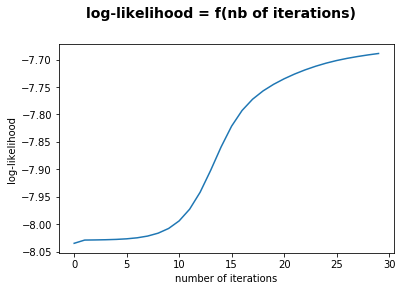

In [35]:
# Plotting the loglik. 
fig = plt.figure()
fig.suptitle('log-likelihood = f(nb of iterations)', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_xlabel('number of iterations')
ax.set_ylabel('log-likelihood')
ax.plot(loglik)
plt.savefig('loglik_3_clusters_30_iterations.png')
plt.show()

In [20]:
loglikelihood = pd.read_csv("loglikelihood.csv", sep=';')

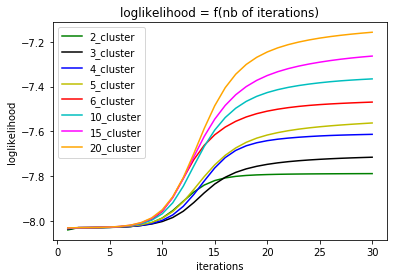

In [21]:
two_cluster, = plt.plot(loglikelihood['Iteration'], loglikelihood['2_cluster'], 'g', label='2_cluster')
three_cluster, = plt.plot(loglikelihood['Iteration'], loglikelihood['3_cluster'], 'k', label='3_cluster')
four_cluster,=plt.plot(loglikelihood['Iteration'], loglikelihood['4_cluster'], 'b', label='4_cluster')
five_cluster,=plt.plot(loglikelihood['Iteration'], loglikelihood['5_cluster'], 'y', label='5_cluster')
six_cluster,=plt.plot(loglikelihood['Iteration'], loglikelihood['6_cluster'], 'r',label='6_cluster')
ten_cluster,=plt.plot(loglikelihood['Iteration'], loglikelihood['10_cluster'], 'c',label='10_cluster')
fifteen_cluster,=plt.plot(loglikelihood['Iteration'], loglikelihood['15_cluster'], 'magenta',label='15_cluster')
twenty_cluster,=plt.plot(loglikelihood['Iteration'], loglikelihood['20_cluster'], 'orange',label='20_cluster')
plt.legend([two_cluster,three_cluster,four_cluster,five_cluster,six_cluster, ten_cluster, fifteen_cluster, twenty_cluster], ['2_cluster', '3_cluster','4_cluster','5_cluster','6_cluster','10_cluster','15_cluster','20_cluster'])
plt.title("loglikelihood = f(nb of iterations)")
plt.xlabel("iterations")
plt.ylabel("loglikelihood")
plt.savefig('multiple.png')
plt.show()

### 2.2.3 Computing the final result and introducing the threshold method

In [36]:
# Our goal here is to compute an RDD gathering the final result which means the tuples: ((u,s); p(s|u)) with (u,s)
# as keys and for all the possible couples (u,s) of our training set (even the couples that was not a clik-log
# in the training set. 


#(u, z, p(z|u)) -> (z, (u,p(z|u)))
Puz_bis = Puz.map(lambda x : (x[0].split(',')[1], \
                 
                 (x[0].split(',')[0],x[1])))

#(s,z, p(s|z)) -> (z, (s,p(s|z)))
Nsz_normalized_bis =  Nsz_normalized.map(lambda x : (x[0].split(',')[1], \
                 (x[0].split(',')[0],x[1])))

# Generating all the possible couples (u,s)
# JOIN --> (z, (u, p(z|u),s, p(s|z)))
final = Puz_bis.join(Nsz_normalized_bis)
# (z, (u, p(z|u),s, p(s|z))) --> ((u,s), p(z|u) * p(s|z))
final = final.map(lambda  x: (x[1][0][0] +','+x[1][1][0], \
                           (x[1][0][1]*x[1][1][1])))
#((u,s), p(z|u) * p(s|z)) --> ((u,s); p(s|u))
final = final.reduceByKey(lambda x,y : x+y)
result = final 
result.persist()

PythonRDD[2141] at RDD at PythonRDD.scala:48

In [37]:
result.take(20)

[('102,2599', 0.0011295927448667434),
 ('102,1341', 9.93421484056972e-05),
 ('102,349', 0.00030380414136750366),
 ('102,7841', 6.087661914754206e-09),
 ('102,4537', 9.934214856880203e-05),
 ('102,6215', 9.934214856874904e-05),
 ('102,7065', 2.9023510908802532e-05),
 ('102,4855', 0.00036737130935736705),
 ('102,8529', 9.180674022934234e-05),
 ('102,5705', 9.212840325138163e-07),
 ('102,1237', 0.0004139330234356138),
 ('102,236', 0.0002764223014668826),
 ('102,4718', 4.509544550325192e-07),
 ('102,66665', 5.081517482820518e-05),
 ('102,7135', 0.00013245609015885204),
 ('102,105954', 2.1703513801105362e-08),
 ('102,56885', 2.6392089704632866e-12),
 ('102,39659', 1.1210099693374801e-10),
 ('102,8239', 8.086146085623974e-05),
 ('102,2884', 3.311404336116794e-05)]

In [38]:
# Here we define a threshold t: if the probability p(s|u) > t, then we predict a click-log (u,s).

# shape - rdd = [('u,s',p(s|u))]



def prediction(rdd, threshold):
    return(rdd.map(lambda x : (x[0],x[1]>=threshold.value)))

# We will define the best value for the threshold after. 

In [39]:
# Computing the clik-log prediction for all the couples (u,s) and for a specific threshold.
#pred_1 = prediction(result,sc.broadcast(.1)) - Division by zero.
#pred_2 = prediction(result,sc.broadcast(.01))
pred_3 = prediction(result,sc.broadcast(.001))
pred_4 = prediction(result,sc.broadcast(.0001))
pred_5 = prediction(result,sc.broadcast(.00001))
pred_6 = prediction(result,sc.broadcast(.000001))

# 3. Algorithm performance : Precision, recall & F1-score

In [40]:
# This function computes the precision and recall of the algorithm /!\/!\ ON THE TEST SET /!\/!\
# This function takes as input the prediction rdd above [('u,s', clik log-boolean)] , a 
# train rdde set with the shape : ['u,s'] and a test rdd set with the shape : ['u,s']
# The ouput is the tupple : (precision,recall, F1 score)

# The idea of the algorithm is described in part 5 of the Latex file. 
# We remove from pred the movies on the training set(films already seen by users) in order to no impact the calculaition
# of False Negatives et False Positives. 


def precisionRecallTest(pred, train, test) :
    # pred is of the form [('u,s', boolean)]
    # train is of the form : ['u,s']
    # test is of the form : ['u,s']
    
    
    # Remove from pred the films already seen by users. To do so we use substractByKey() so we need 
    # to append something to the train rdd
    to_remove = train.map(lambda x : (x,1))
    predict = pred.subtractByKey(to_remove)
    
    
    # positive predictions (we predict that user u has seen film s)
    pos = predict.filter(lambda x : x[1])\
                 .map(lambda x : x[0])
    # Number of positive predictions
    nb_pos = pos.count()
    # Number of true positivies
    nb_TP = pos.intersection(test).count() 
    # Number of false positives
    nb_FP = nb_pos - nb_TP 
    
    #negatives predictions (we predict that user u has never seen film s)
    # Same spirit. 
    neg = predict.filter(lambda x : not(x[1]))\
                 .map(lambda x : x[0])
    nb_neg = neg.count()
    nb_FN = neg.intersection(test).count() # Our negative predictions are actually in the train set
    nb_TN = nb_neg - nb_FN
    
    
    # compute precision and recall
    precision = nb_TP / (nb_FP + nb_TP)
    recall = nb_TP / (nb_FN + nb_TP)
    F1_score = 2 * (precision * recall)/(precision + recall)
    
    return((precision,recall, F1_score))




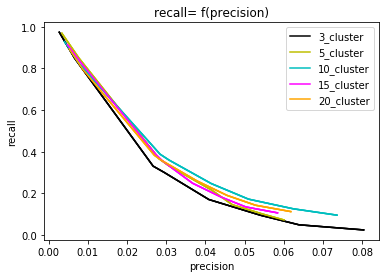

In [43]:
#Plotting some results of the optimization 


precision_20 = [0.06179838984011793,
0.05281031785400847,
0.0455299037438448,
0.03793495565158062,
0.028900911161731206,
0.026981093540292933,
0.008732843759643534,
0.00525162140306895]
recall_20 = [ 0.1129065672260203,
0.14336026517505698,
0.19059457219805262,
0.2591671845866998,
0.35746840687797804,
0.3831572405220634,
0.7943857468406877,
0.892686969131966]


precision_15 = [0.05842021758839529,
0.05034165926726634,
0.044070854107684215,
0.03674524621762609,
0.028982459092247507,
0.027347324193158776,
0.00865213213647514,
0.0047596254250340106]
recall_15 = [0.10679511083488709,
0.13507354464470686,
0.18220426766107314,
0.24880878392376218,
0.3568469028382018,
0.3869898487673503,
0.8180029003521856,
0.9136109384711001]


precision_10 = [0.07359376243137879,0.062439174307227376,0.051000428317934283,0.041507268553940324,
                0.030738738419883734,0.028419815790471138,0.007666534158668863,0.004036308767714573]
recall_10 = [0.09581520613217319,0.12626890408120986,0.1726745390511705,0.24725502382432152,
0.3598508390304537,0.3883364408535322,0.8250466128029832,0.9285270354257302]


precision_5 = [0.0600788481316421,
0.0546227893440788,
0.04691621865295355,
0.0415425553040232,
0.03053153791637137,
0.028176641580058136,
0.007693692747447314,
0.0033626281671464]
recall_5 = [0.07261238864719287,
0.10109799047027139,
0.14553552931427388,
0.21669774186865548,
0.33467992541951525,
0.3664802154547338,
0.8498031903874042,
0.9681997099647814]

precision_3 = [0.08041374708041375,
0.06389520117631332,
0.05404612405375271,
0.04088666286479383,
0.02942365617482362,
0.02666321727809861,
0.00661169160069094,
0.0027037463980262304]
recall_3 = [0.024963745597679717,
0.04951315516884193,
0.09540087010565569,
0.17081002693184172,
0.30153304329811476,
0.3309509011808577,
0.8488709343277397,
0.9732753262896209]




#plt.plot(precision_20, recall_20)


three_cluster, = plt.plot(precision_3, recall_3, 'k', label='3_cluster')
five_cluster,=plt.plot(precision_5, recall_5, 'y', label='5_cluster')
ten_cluster,=plt.plot(precision_10, recall_10, 'c',label='10_cluster')
fifteen_cluster,=plt.plot(precision_15, recall_15, 'magenta',label='15_cluster')
twenty_cluster,=plt.plot(precision_20, recall_20, 'orange',label='20_cluster')
plt.legend([three_cluster,five_cluster, ten_cluster, fifteen_cluster, twenty_cluster], [ '3_cluster','5_cluster','10_cluster','15_cluster','20_cluster'])
plt.title("recall= f(precision)")
plt.xlabel("precision")
plt.ylabel("recall")
plt.savefig('precision_recall.png')

plt.show()